Optimization terminated successfully.
         Current function value: 0.083726
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   60
Model:                          Logit   Df Residuals:                       58
Method:                           MLE   Df Model:                            1
Date:                Wed, 22 May 2024   Pseudo R-squ.:                  0.8732
Time:                        14:46:57   Log-Likelihood:                -5.0236
converged:                       True   LL-Null:                       -39.632
Covariance Type:            nonrobust   LLR p-value:                 8.824e-17
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3393      1.396      2.392      0.017       0.603       6.075
V              8.8712      3

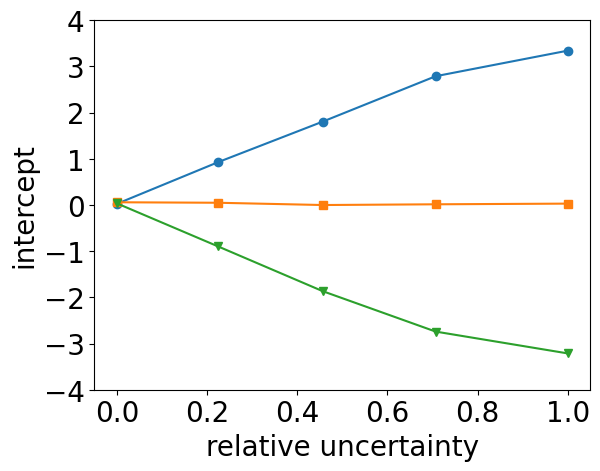

In [1]:
import pandas as pd
import numpy as np
from statsmodels.discrete.discrete_model import Probit
from statsmodels.discrete.discrete_model import  Logit
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sn
plt.style.use('default')
def standardization(data):
    data = np.array(data)
    mu = np.mean(data, axis=0)
    print(mu)
    sigma = np.std(data, axis=0)
    print(sigma)
    return (data ) / (sigma + 1e-9)


def plot_logit(w=None, b=None, label=None):
    x = np.arange(-1.5,1.5,0.05)
    y = 1. / (1+np.exp(-(x*w + b)))
    plt.plot(x, y, label=label)
    # plt.show()

if __name__ == '__main__':

    TU = 2.5
    r1_var_list = [2.25,2.,1.75,1.5,1.25]
    n = len(r1_var_list)
    modes = ['seeking','neutral','averse']
    labels = ['optimistic', 'neutral','conservative']
    fmts = ['o-', 's-', 'v-']
    for i,mode in enumerate(modes):
        b_list = []
        b_std_list = []
        w_list = []
        w_std_list = []
        RU_list = []
        for (index, r1_var) in enumerate(r1_var_list):
            r1_std = np.sqrt(r1_var)
            r2_std = np.sqrt(TU - r1_var)
            RU = r1_std - r2_std
            p_list_combined = []
            for times in range(10):
                p_list = np.load(f'saved/simulation_TU={TU}_var={r1_var}_{mode}_{times}_n=2.npy')
                p_list = p_list[np.newaxis, :]
                if times == 0:
                    p_list_combined = p_list
                else:
                    p_list_combined = np.concatenate([p_list_combined, p_list], axis=0)
            p_mean = np.mean(p_list_combined, axis=0)
            p_std = np.std(p_list_combined, axis=0)

            V_list = np.arange(-1.5, 1.5, 0.05)
            X = np.array(V_list).T
            X = pd.DataFrame(X, columns=['V'])
            X = sm.add_constant(X)
            Y = p_mean
            model = Logit(Y, X)
            # model = MixedLM(Y, X)
            Logit_model = model.fit()
            v = Logit_model.params['V']
            v_std = Logit_model.bse['V']
            const = Logit_model.params['const']
            const_std = Logit_model.bse['const']
            b_list.append(const)
            b_std_list.append(const_std)
            w_list.append(v)
            w_std_list.append(v_std)
            RU_list.append(RU)
            print(Logit_model.summary())
            # plot_logit(v, const, label=f'{RU}')

        # plt.plot(RU_list, b_list, label='bias')
        plt.errorbar(RU_list, b_list,fmt=fmts[i],elinewidth=2,capsize=5, label=labels[i])
        # plt.title(f'{mode}')
    plt.xlabel('relative uncertainty', size=20)
    plt.ylabel('intercept', size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.ylim(-4,4)
    # plt.legend(prop={'size': 13})
    plt.show()